## Gradient-Based Learning Applied to Document Recognition (LeNet Paper)

Original paper: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

In [1]:
import pandas as pd
import math
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import trange
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Fixes matplotlib crashing jupyter kernel issue (should find out what this actually does, something to do with OpenMP?)
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# Load the mnist dataset and rescale images to 0-1
# MNIST fetching reference: https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28)) / 255.0
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28)) / 255.0
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
# Resize images to 32x32 to match paper
def transform(arr):
    resized_lst = []
    
    for img in arr:
        resized_lst.append(Image.fromarray(img).resize((32,32)))
        
    ret = np.stack(resized_lst, axis=0)
    ret = ret.reshape(-1, 1, 32, 32)
    
    return ret

X_train = transform(X_train)
X_test = transform(X_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(60000, 1, 32, 32)
(60000,)
(10000, 1, 32, 32)
(10000,)


In [4]:
# First implement in PyTorch
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.c1 = torch.nn.Conv2d(1, 6, 5)
        self.s2 = torch.nn.AvgPool2d(2, 2)  # Not quite the sub-sampling from the original which had trainable params
        self.c3 = torch.nn.Conv2d(6, 16, 5) # Also not the same, the way they achieve this shape in the paper is interesting
        self.s4 = torch.nn.AvgPool2d(2,2)   # Not quite the sub-sampling from the original which had trainable params
        self.c5 = torch.nn.Conv2d(16, 120, 5) # Generates 1x1 output convolutions, so essentially it's an fc layer
        self.f6 = torch.nn.Linear(120, 84)
        self.f7 = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.tanh(self.c1(x))
        x = self.s2(x)
        x = F.tanh(self.c3(x))
        x = self.s4(x)
        x = F.tanh(self.c5(x))
        x = x.view(-1, 120) # change the view so we can pass the 1x1 convolutions to the next fc layer
        x = F.tanh(self.f6(x))
        x = self.f7(x)
        return x

In [8]:
# Pre-training definitions
model = LeNet()
batch_size = 128
loss_fun = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.1)

losses = []
accuracies = []

for i in (t := trange(2500)):
    # Create batch
    batch_idx = np.random.randint(0, X_train.shape[0], size=(batch_size))
    data = torch.tensor(X_train[batch_idx]).float()
    labels = torch.tensor(Y_train[batch_idx]).long()
    
    # Run model and backprop
    outputs = model(data)
    loss = loss_fun(outputs, labels)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    # Calculate accuracy
    out_labels = torch.argmax(outputs, dim=1)
    acc = (out_labels == labels).float().mean()
    losses.append(loss.item())
    accuracies.append(acc.item())
    
    # For tqdm
    t.set_description(f"Loss: {loss:.2f} Accuracy: {acc:.2f}")

Loss: 0.03 Accuracy: 0.99: 100%|███████████████████████████████████████████████████| 2500/2500 [01:03<00:00, 39.23it/s]


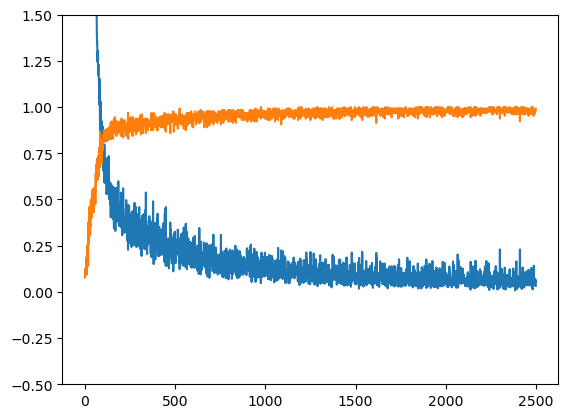

In [9]:
plt.ylim(-0.5, 1.5)
plt.plot(losses)
plt.plot(accuracies)

In [10]:
# Evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.983